**Version 2** - Height=600, Width=300

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import ast
from glob import glob
import pickle
from pprint import pprint
import random
import traceback
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from PIL import Image

import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams["figure.figsize"] = (12, 9)
sns.set_style("dark")

In [4]:
IMG_HEIGHT = 300
IMG_WIDTH = 600

## Load Test Data

In [5]:
test_images = glob("../input/arya-hw-lines/test/test/*.tif")

In [6]:
len(test_images)

994

## Word Level Separation

https://stackoverflow.com/questions/37771263/detect-text-area-in-an-image-using-python-and-opencv

In [7]:
!mkdir test_images

In [8]:
def get_splits(test_images, plot=True):
    image_paths, image_splits, image_counts = [], [], []
    count, error_cases = 0, 0
    for idx, path in tqdm(enumerate(test_images)):
        prev_count = count
        try:
            # Load image, grayscale, Gaussian blur, adaptive threshold
            image = cv2.imread(path, 0)
            blur = cv2.GaussianBlur(image, (9,9), 0)
            thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 30)

            # Dilate to combine adjacent text contours
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
            dilate = cv2.dilate(thresh, kernel, iterations=4)

            # Find contours, highlight text areas, and extract ROIs
            cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = cnts[0] if len(cnts) == 2 else cnts[1]
            # Sorting contours along x-axis
            cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

            for c in cnts:
                area = cv2.contourArea(c)
                if area > 2000:
                    x, y, w, h = cv2.boundingRect(c)
                    if plot:
                        cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 3)
                    word_img = image[y:y+h, x:x+w]
                    try:
                        # padding to right & bottom
                        word_img = np.pad(word_img, 
                                           ((0, IMG_HEIGHT-h), (0, IMG_WIDTH-w)),
                                           'constant',
                                           constant_values=255)
                    except ValueError:
                        pass # index can't contain negative values
                    except Exception as e:
                        error_cases += 1
                        print(idx, e)
                        traceback.print_exc()
                    cv2.imwrite(f"test_images/{count}.png", word_img)
                    count += 1
            image_splits.append(list(range(prev_count, count)))
            image_paths.append(path)
            image_counts.append(count-prev_count)

            if plot:
                plt.figure()
                plt.imshow(thresh)
                plt.figure()
                plt.imshow(image)
        except Exception as e:
            error_cases += 1
            print(path, e)
            traceback.print_exc()
    
    print(f"# Error Cases: {error_cases}")
    df = pd.DataFrame.from_dict({"Path": image_paths, "Splits": image_splits, "NumSplits": image_counts})
    return df

> In case of padding issue - store the image as is. The downside will be that when resizing, the image will be stretched

0it [00:00, ?it/s]

# Error Cases: 0


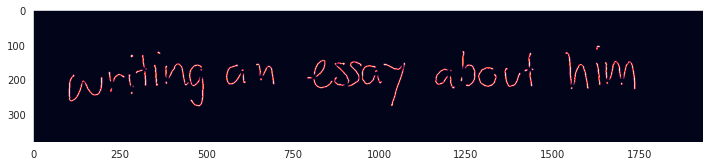

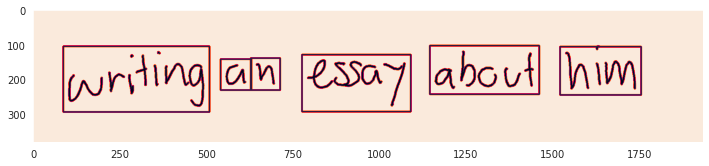

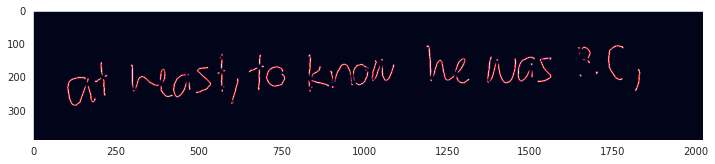

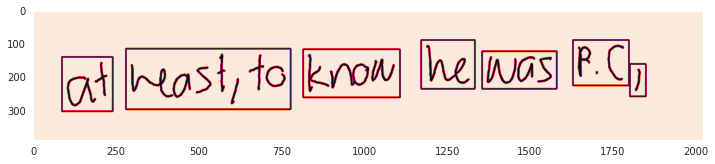

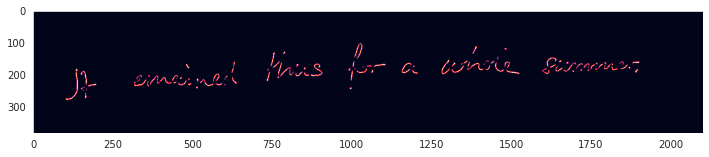

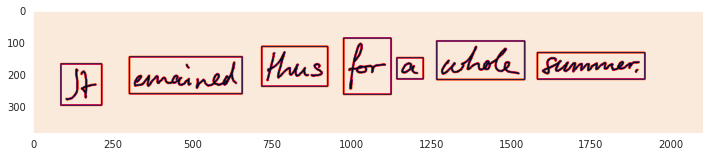

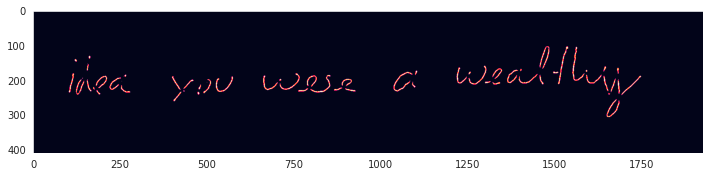

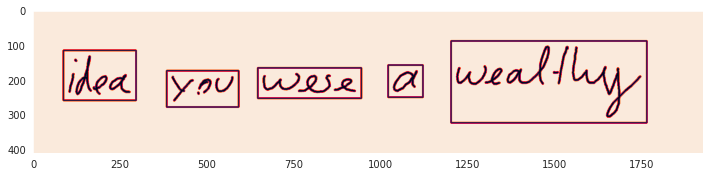

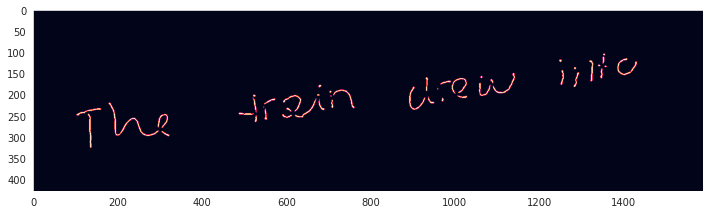

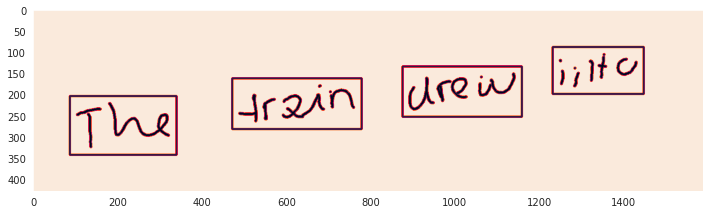

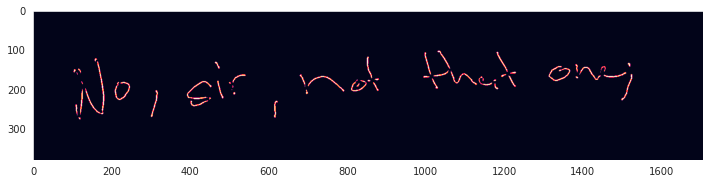

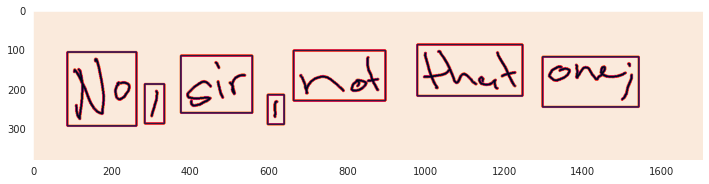

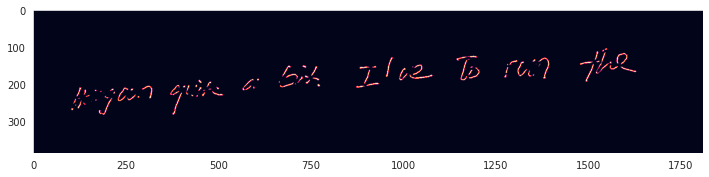

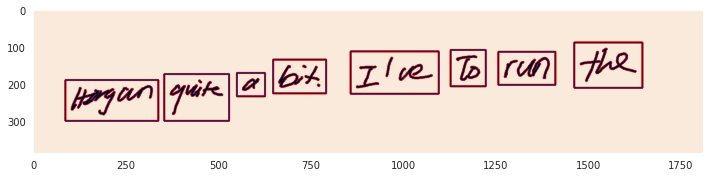

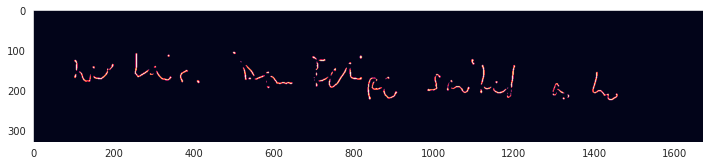

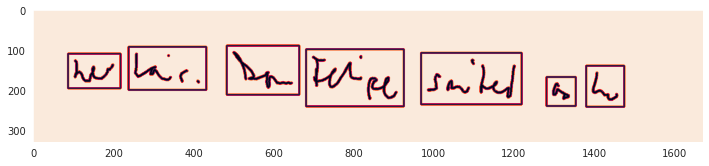

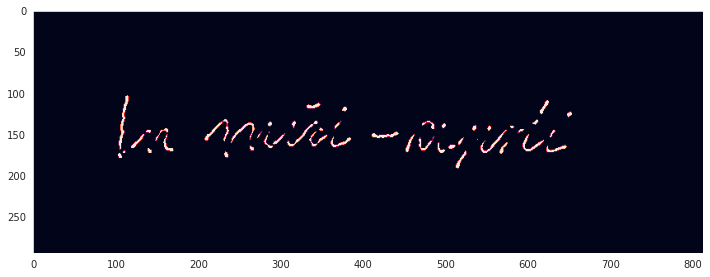

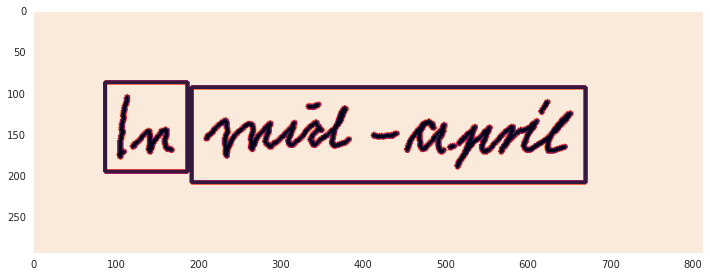

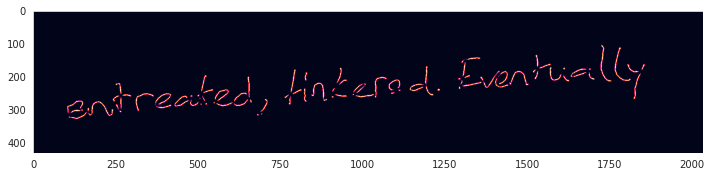

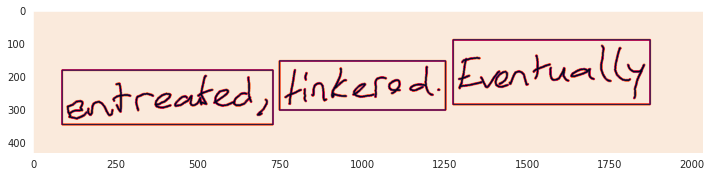

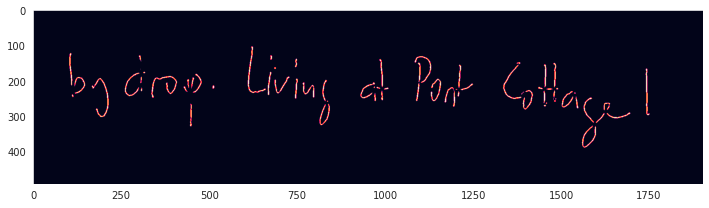

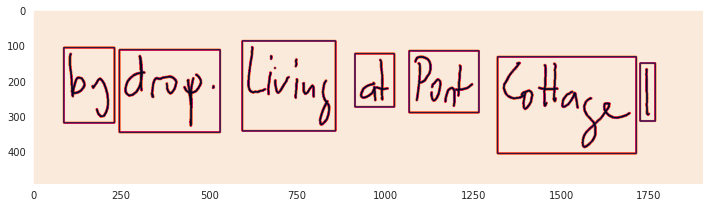

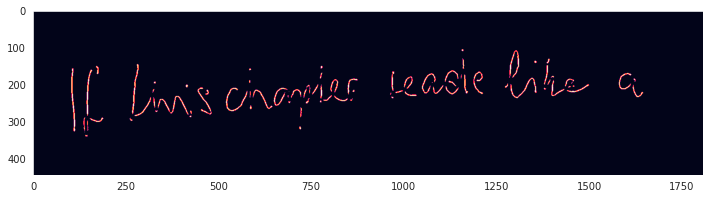

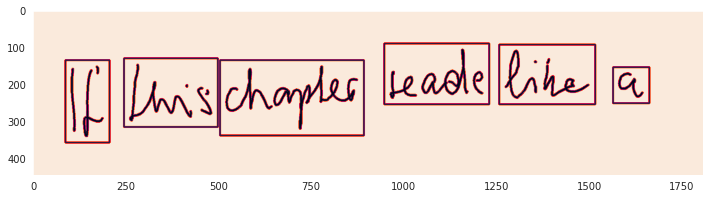

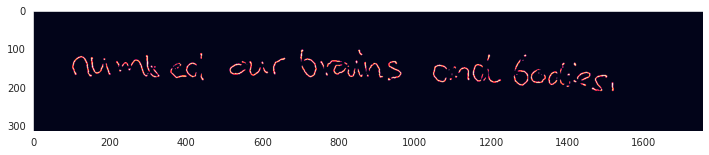

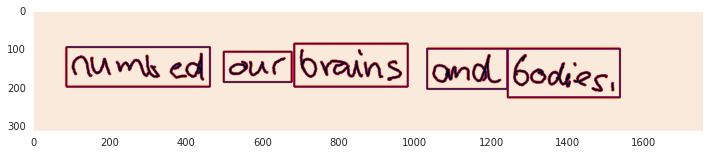

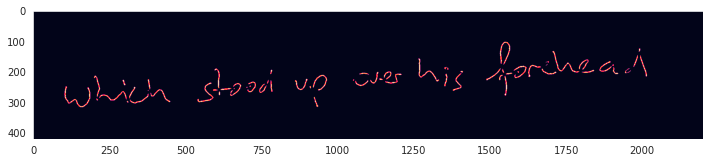

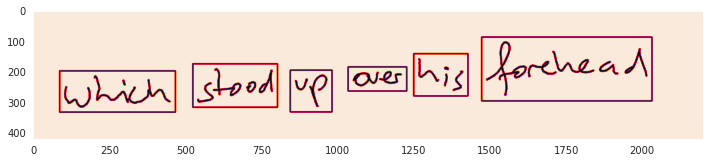

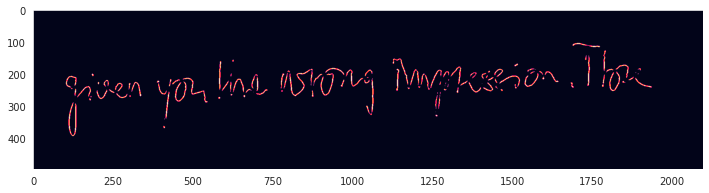

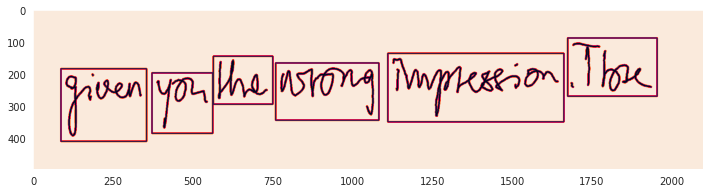

In [9]:
_ = get_splits(test_images[:15], plot=True)

In [10]:
test_df = get_splits(test_images, plot=False)

0it [00:00, ?it/s]

# Error Cases: 0


In [11]:
test_df.shape

(994, 3)

In [12]:
test_df.head()

,Path,Splits,NumSplits
0,../input/arya-hw-lines/test/test/r07-568z-05.tif,"[0, 1, 2, 3, 4, 5]",6
1,../input/arya-hw-lines/test/test/r07-568z-07.tif,"[6, 7, 8, 9, 10, 11, 12]",7
2,../input/arya-hw-lines/test/test/r08-612z-05.tif,"[13, 14, 15, 16, 17, 18, 19]",7
3,../input/arya-hw-lines/test/test/p07-917z-05.tif,"[20, 21, 22, 23, 24]",5
4,../input/arya-hw-lines/test/test/r02-091z-01.tif,"[25, 26, 27, 28]",4


In [13]:
test_df.sample(n=5)

,Path,Splits,NumSplits
393,../input/arya-hw-lines/test/test/r02-112z-04.tif,"[2226, 2227, 2228, 2229]",4
515,../input/arya-hw-lines/test/test/r06-468z-06.tif,"[2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917]",8
217,../input/arya-hw-lines/test/test/p08-012z-06.tif,"[1231, 1232, 1233, 1234, 1235, 1236]",6
157,../input/arya-hw-lines/test/test/p08-996z-01.tif,"[884, 885, 886, 887, 888, 889]",6
724,../input/arya-hw-lines/test/test/p08-045z-01.tif,"[4114, 4115, 4116, 4117, 4118, 4119, 4120]",7


In [14]:
def plot_words(image_splits):
    num_cols = 4
    num_rows = len(image_splits)//num_cols
    num_rows = num_rows+1 if len(image_splits)%num_cols else num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    axes = axes.flatten()
    for idx, img in enumerate(image_splits):
        axes[idx].imshow(img)
        axes[idx].axis("off")
    plt.tight_layout()

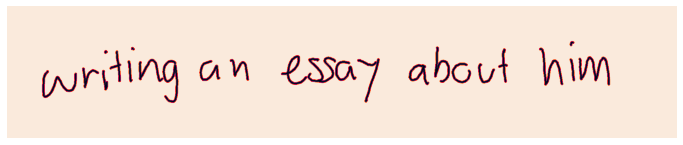

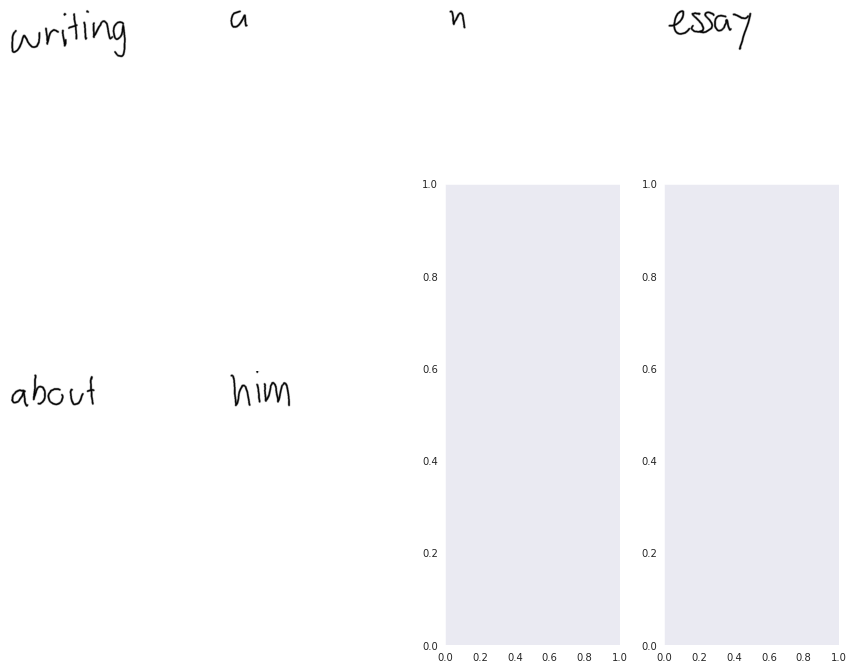

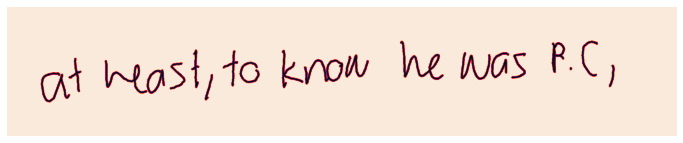

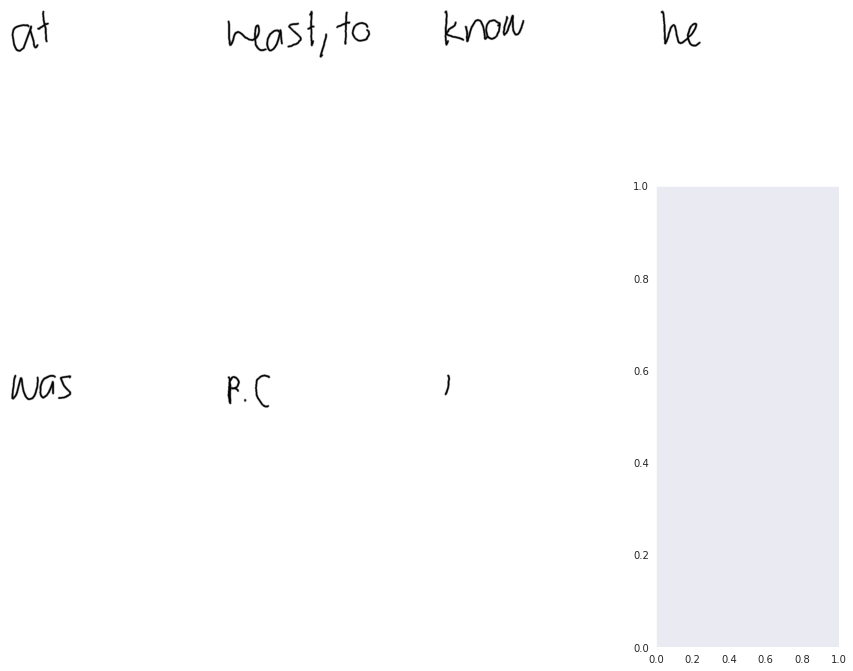

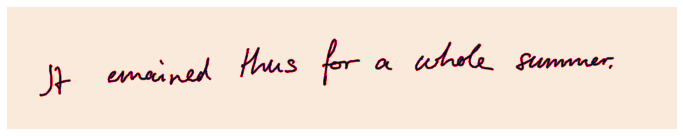

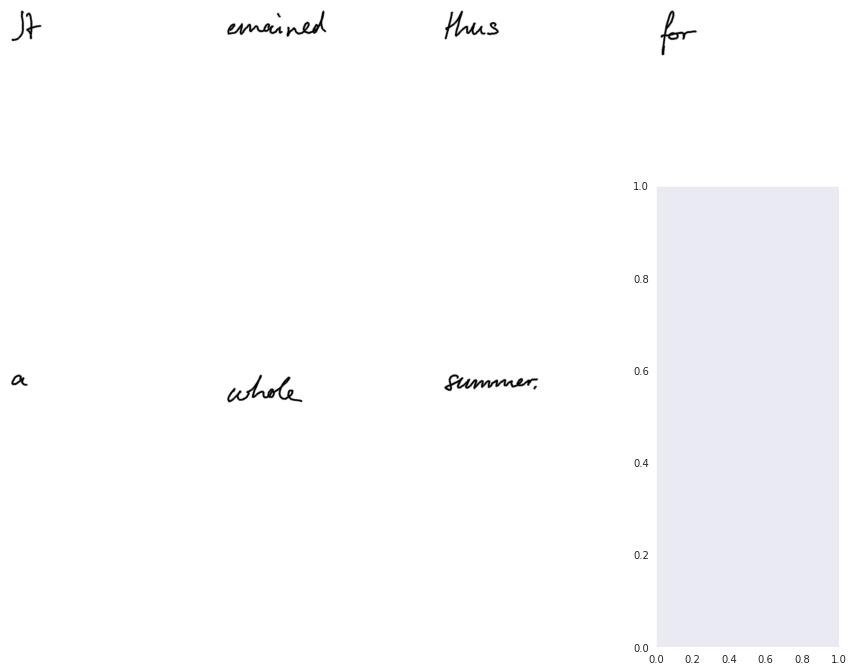

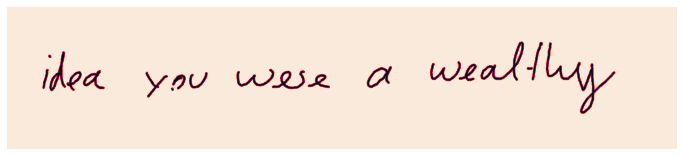

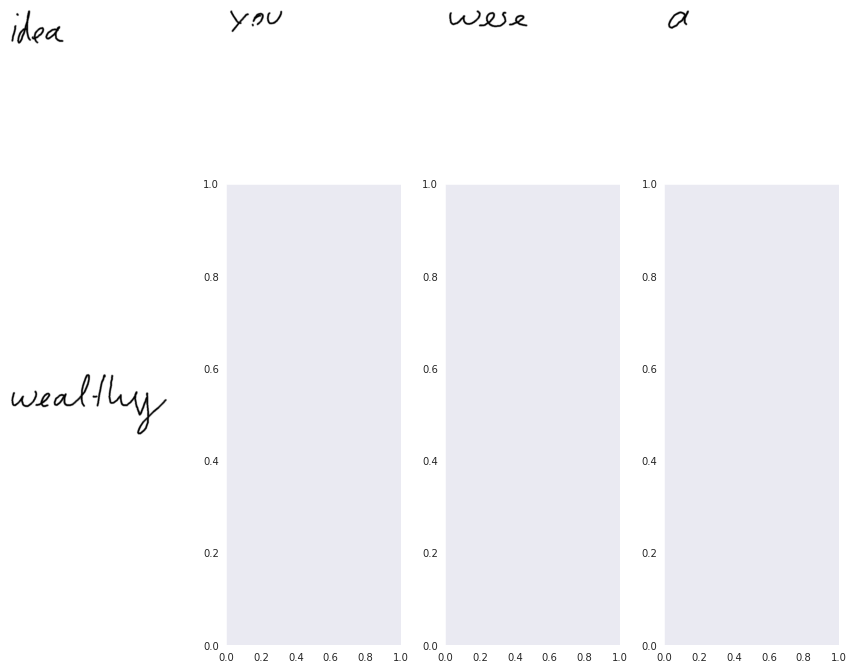

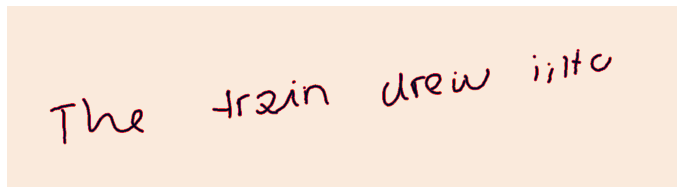

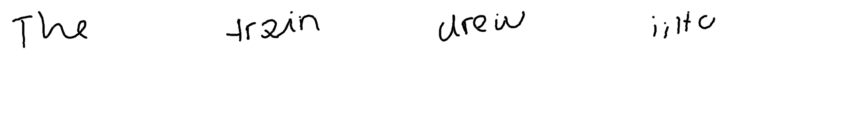

In [15]:
for idx in range(5):
    image = cv2.imread(test_df["Path"].iloc[idx], 0)
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    image_splits = [cv2.imread(f"test_images/{x}.png") for x in test_df["Splits"].iloc[idx]]
    plot_words(image_splits)

In [16]:
test_df["NumSplits"].value_counts()

6     264
5     210
7     189
4     113
8      85
3      57
9      29
2      21
1      20
10      4
11      2
Name: NumSplits, dtype: int64

In [17]:
test_df.to_csv("test_csv.csv", index=False)

In [18]:
!zip --quiet -r test_images.zip test_images
!rm -rf test_images

In [19]:
!unzip -l test_images.zip | wc

   5651   22599  287003
